# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Заказчик требует, чтобы метрика качества *accuracy* была не менее 0.75.

Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

План работы

1. Изучим данные.
2. Разделим данные на три выборки.
3. Исследуем модели классификации: дерево решений, случайный лес, логистическая регрессия.
4. Подберем лучшие гиперпараметры.
5. Проверим модель на тестовой выборке.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Изучим файл

In [2]:
df = pd.read_csv('users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В наших данных присутствует информация о 3214 клиентах. Датафрейм не требует предобработки.

Столбец is_ultra это целевой параметр.

## Разобьем данные на выборки

Разобьем данные на обучающую, валидационную и тестовую в соотношении 3:1:1

Для начала разделим датасет на тренировочный и тестовый.

In [5]:
df_learn, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
display(df_learn.shape)
df_test.shape

(2571, 5)

(643, 5)

Разделим тренировочные данные на обучающие и валидационные.

In [7]:
df_train, df_valid = train_test_split(df_learn, test_size=0.25, random_state=42)

In [8]:
display(df_train.shape)
df_valid.shape

(1928, 5)

(643, 5)

На данном шаге мы разбили данные на три выборки и проверили их размер.

## Исследуем модели

Решим задачу классификации.

Исследуем 3 модели: дерево решений, случайный лес и логистическую регрессию.

Объявим переменные с целевыми признаками и остальными признаками для каждой выборки.

In [9]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

### Дерево решений.

In [10]:
depth_values = range(1, 50)

In [11]:
best_model_tree = None
best_criterion = None
best_result_tree = 0
best_depth = 0

In [12]:
for depth in depth_values:
    for criterion in ['gini', 'entropy']:
        model = DecisionTreeClassifier(criterion=criterion, random_state=42, max_depth=depth)
        model.fit(features_train, target_train)  # обучим модель на тренировочных данных
        predictions_valid = model.predict(features_valid)  # найдем предсказания на валидационной выборке
        valid_score = accuracy_score(target_valid, predictions_valid)

        if valid_score > best_result_tree:
            best_model_tree = model
            best_result_tree = valid_score
            best_depth = depth
            best_criterion = criterion

In [13]:
print('Accuracy лучшей модели:', best_result_tree.round(2))
print('Depth лучшей модели:', best_depth)
print('Criterion лучшей модели:', best_criterion)

Accuracy лучшей модели: 0.79
Depth лучшей модели: 5
Criterion лучшей модели: entropy


### Случайный лес

In [14]:
scores_data_forest = pd.DataFrame()

In [15]:
best_model_forest = None
best_result_forest = 0
best_est = 0

In [16]:
for est in range(1, 50):
    model = RandomForestClassifier(random_state=42, n_estimators=est)  # обучим модель с заданным количеством деревьев
    model.fit(features_train, target_train)  # обучим модель
    result = model.score(features_valid, target_valid)

    # Занесем в таблицу значения accuracy и est
    temp_score_data = pd.DataFrame({'est': [est],
                                          'accuracy': [result]
                                         })
    scores_data_forest = pd.concat([scores_data_forest, temp_score_data])    
    
    if result > best_result_forest:
        best_model_forest = model  # сохраним наилучшую модель
        best_result_forest = result  # сохраним наилучшее значение accuracy
        best_est = est

In [17]:
scores_data_forest.head()

,est,accuracy
0,1,0.712286
0,2,0.757387
0,3,0.738725
0,4,0.768274
0,5,0.762053


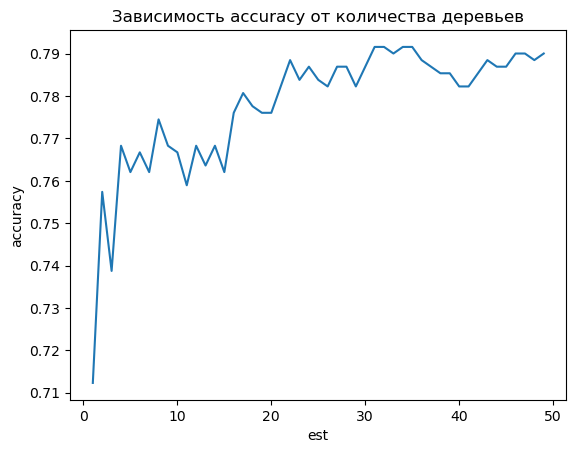

In [18]:
sns.lineplot(x='est', y='accuracy', data=scores_data_forest);
plt.title('Зависимость accuracy от количества деревьев');

In [19]:
print('Accuracy лучшей модели:', best_result_forest.round(2))
print('Количество деревьев лучшей модели:', best_est)

Accuracy лучшей модели: 0.79
Количество деревьев лучшей модели: 31


### Логистическая регрессия

In [20]:
best_model_reg = None
best_result_reg = 0
best_max_iter = 0

In [21]:
for max_iter in range(50, 1000):
    model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=max_iter)  # создадим модель
    model.fit(features_train, target_train)
    predictons_valid = model.predict(features_valid)
    regression_score = accuracy_score(target_valid, predictions_valid)
        
    if regression_score > best_result_reg:
        best_model_reg = model
        best_result_reg = regression_score
        best_max_iter = max_iter

In [22]:
print('Accuracy модeли логистической регрессии:', best_result_reg.round(2))
print('max_iter:', best_max_iter)

Accuracy модeли логистической регрессии: 0.72
max_iter: 50


**Вывод: Наиболее высокий показатель accuracy у дерева решений и случайного леса - 0.79. Самое низкое качество предсказаний у логистической регрессии - 0.72.**

## Проверим модель на тестовой выборке

In [25]:
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

Проверим модель дерева решений на тестовой выборке.

In [26]:
predictions_test = best_model_tree.predict(features_test)
result_test = accuracy_score(target_test, predictions_test)
print('Accuracy модели дерева решений для тестовой выборки:', result_test.round(2))

Accuracy модели дерева решений для тестовой выборки: 0.8


Проверим модель случайного леса на тестовой выборке.

In [27]:
predictions_test = best_model_forest.predict(features_test)
result_test = accuracy_score(target_test, predictions_test)
print('Accuracy модели случайного леса для тестовой выборки:', result_test.round(2))

Accuracy модели случайного леса для тестовой выборки: 0.8


Проверим модель логистической регрессии на тестовой выборке.

In [28]:
predictions_test = best_model_reg.predict(features_test)
result_test = accuracy_score(target_test, predictions_test)
print('Accuracy модели логистической регрессии для тестовой выборки:', result_test.round(2))

Accuracy модели логистической регрессии для тестовой выборки: 0.7


Для решения нашей задачи используем модель случайного леса, которое дает значение accuracy = 0.8

## Проверим модели на адекватность

In [29]:
from sklearn.dummy import DummyClassifier

In [30]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(features_train, target_train)
dummy_model.predict(features_test)
print('Accuracy:', dummy_model.score(features_test, target_test).round(2))

Accuracy: 0.71


## Вывод

В данном проекте мы выполнили следующие этапы:

1. Изучили датасет с данными.
2. Разбили данные на три выборки: обучающую, валидационную и тестовую в соотношении 3:1:1.
3. Исследовали три модели: дерево решений, случайный лес, логистическая регрессия.
4. Определили лучшие гиперпараметры.
5. Проверили качество модели на тестовых данных и определили лучшую модель - случайный лес. Значение accuracy = 0.8.